# Exfoliation Energy

In this notebook, we train an XGBoost regressor to predict exfoliation energies normalized by surface area, to eV/(atom*Å^2).

In [1]:
import copy

import pandas as pd
import numpy as np
import optuna
import xgboost
import imblearn.over_sampling
import sklearn.model_selection
import dscribe.descriptors
import tqdm
import sklearn.pipeline

import functools

import matplotlib.pyplot as plt
import sklearn.impute
import seaborn as sns

import sys
sys.path.append("../../../")
import DigitalEcosystem.utils.figures
from DigitalEcosystem.utils.misc import matminer_descriptors
from DigitalEcosystem.utils.element_symbols import noble_gases, f_block_elements, synthetic_elements_in_d_block

tqdm.tqdm.pandas()

In [2]:
# Random seeds for reproducibility
RANDOM_SEED = 1234
import random
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Read in the Dataset

In [3]:
# Load up the data
data_path = "../../refined/httpot/full_featurized_data.pkl"
data = pd.read_pickle(data_path)

# Filter out by several masks

- `element_mask` - throw away systems containing noble gases, f-blocks, or any synthetic elements
- `decomposition_mask` - keep systems with a decomposition energy < 0.5 eV/atom
- `exfoliation_mask` - keep systems with an exfoliation energy > 0 eV/atom

In [4]:
bad_elements = noble_gases + f_block_elements + synthetic_elements_in_d_block

element_mask = data['atoms_object (unitless)'].apply(lambda atoms: all([forbidden not in atoms.get_chemical_symbols() for forbidden in bad_elements]))

decomposition_mask = data['decomposition_energy (eV/atom)'] < 0.5

exfoliation_mask = data['exfoliation_energy_per_atom (eV/atom)'] > 0

reasonable = data[element_mask & decomposition_mask & exfoliation_mask]

# Normalize by Surface Area

In [5]:
surface_areas = reasonable['atoms_object (unitless)'].apply(lambda atoms: atoms.get_cell()).apply(lambda cell: np.linalg.norm(np.cross(cell[0], cell[1])))

target_column = 'exfoliation_energy (eV/atom*area)'
reasonable[target_column] = reasonable['exfoliation_energy_per_atom (eV/atom)'] / surface_areas

<ipython-input-5-c9746bbad0d3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reasonable[target_column] = reasonable['exfoliation_energy_per_atom (eV/atom)'] / surface_areas


# Descriptor selection

XenonPy and Matminer

In [6]:
xenonpy_descriptors = [col for col in data.columns if ":" in col]
xenonpy_matminer_descriptors = xenonpy_descriptors + matminer_descriptors

And finally, do a train/test split

In [7]:
train, test = sklearn.model_selection.train_test_split(reasonable, test_size=0.1, random_state=RANDOM_SEED)

In [8]:
train_x_regression = np.nan_to_num(train[xenonpy_matminer_descriptors].to_numpy())
train_y_regression = np.nan_to_num(train[target_column].to_numpy())

test_x_regression = np.nan_to_num(test[xenonpy_matminer_descriptors].to_numpy())
test_y_regression = np.nan_to_num(test[target_column].to_numpy())

# XGBoost Hyperparameter Tuning

Tune an XGBoost regressor for the exfoliation energy using Optuna.

In [9]:
current_regression = None
best_regression = None
def keep_best_regression(study, trial):
    global best_regression
    if study.best_trial == trial:
        best_regression = current_regression

def objective(trial: optuna.Trial):
    global current_regression

    SEED = trial.suggest_categorical('random', [42,1234,12345])
    objective_train_x_regression, objective_validation_x_regression, objective_train_y_regression, objective_validation_y_regression = sklearn.model_selection.train_test_split(
    np.nan_to_num(train_x_regression), train_y_regression, test_size=0.1, random_state=SEED)

    current_regression = sklearn.pipeline.Pipeline([
        ("Scaler", sklearn.preprocessing.MinMaxScaler()),
        ("XGB_Regressor", xgboost.sklearn.XGBRegressor(
            max_depth= trial.suggest_int('max_depth', 1, 50),
            min_child_weight= trial.suggest_float('min_child_weight', 0, 10),
            reg_alpha = trial.suggest_float('alpha', 0, 10),
            reg_lambda = trial.suggest_float('lambda', 0, 10),
            colsample_bytree=trial.suggest_float('colsample_bytree', 0,1),
            subsample=trial.suggest_float('subsample', .1,1),
            learning_rate=trial.suggest_float('learning_rate', 0.001, 1),
            n_estimators=1000,
            objective='reg:pseudohubererror',
            random_state=SEED)),
    ])

    current_regression.fit(X=objective_train_x_regression, y=objective_train_y_regression,
                         **{
                            'XGB_Regressor__verbose': False
                         })

    score = sklearn.metrics.r2_score(
        y_true=objective_validation_y_regression,
        y_pred=abs(current_regression.predict(objective_validation_x_regression)),
    )

    return score

regression_study = optuna.create_study(
    sampler = optuna.samplers.TPESampler(
        seed = RANDOM_SEED,
        warn_independent_sampling = True,
        consider_endpoints = True
    ),
    direction='maximize'
)

regression_study.optimize(func=objective, n_trials=128, callbacks=[keep_best_regression])

[I 2021-08-30 11:28:16,916] A new study created in memory with name: no-name-118cc5b0-027f-4ff9-88f7-e7f1c8e85440
[I 2021-08-30 11:28:19,744] Trial 0 finished with value: 0.23713684678520208 and parameters: {'random': 1234, 'max_depth': 40, 'min_child_weight': 7.799758081188035, 'alpha': 2.7259260528264164, 'lambda': 2.764642551430967, 'colsample_bytree': 0.8018721775350193, 'subsample': 0.9623254183153347, 'learning_rate': 0.8760567021073526}. Best is trial 0 with value: 0.23713684678520208.
[I 2021-08-30 11:28:20,821] Trial 1 finished with value: 0.008401626051532052 and parameters: {'random': 12345, 'max_depth': 36, 'min_child_weight': 3.7025075479039495, 'alpha': 5.611961860656249, 'lambda': 5.030831653078097, 'colsample_bytree': 0.013768449590682241, 'subsample': 0.7955439594511367, 'learning_rate': 0.8827585494454805}. Best is trial 0 with value: 0.23713684678520208.
[I 2021-08-30 11:28:23,080] Trial 2 finished with value: -0.020283464446977817 and parameters: {'random': 1234, 'm

# Save summary statistics

- A parity plot for the model and the entire data range
    - Also for a subset of the range
- Model performance statistics are also printed


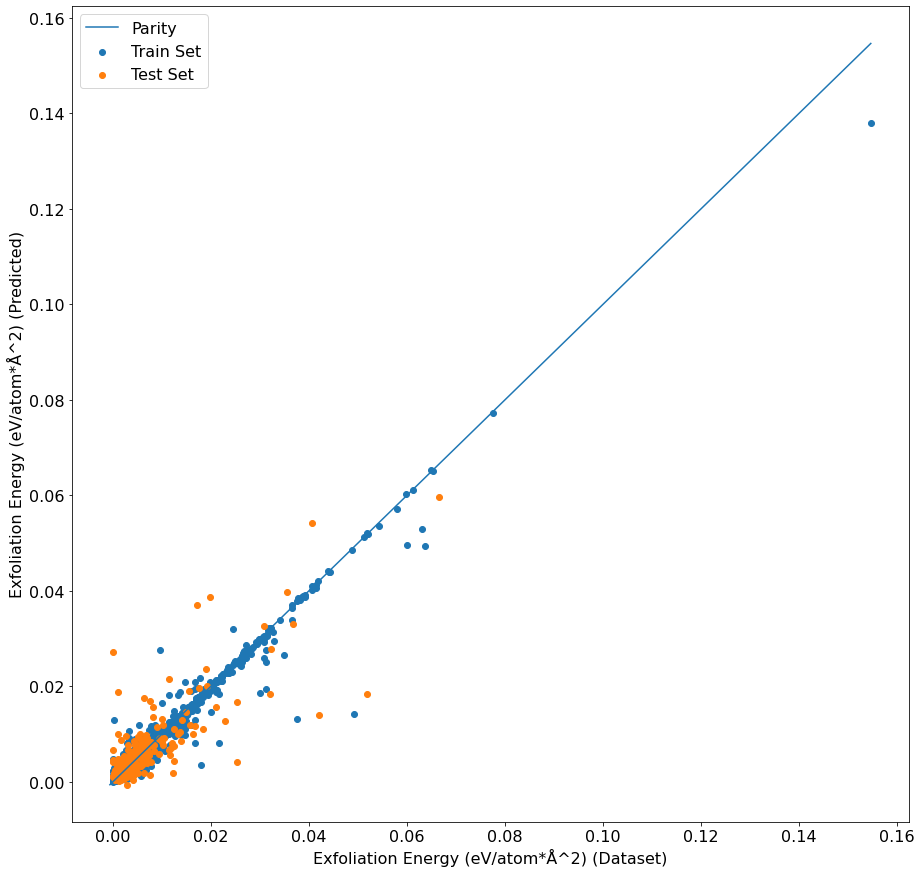

In [16]:
DigitalEcosystem.utils.figures.save_parity_plot(train_x_regression,
                                                test_x_regression,
                                                train_y_regression,
                                                test_y_regression,
                                                best_regression,
                                                "Exfoliation Energy (eV/atom*Å^2)",
                                                "exfoliation_per_atom.jpeg")

In [11]:
def rmse(y_true, y_pred):
    mse = sklearn.metrics.mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(abs(mse))
    return rmse

metrics = {
    'MaxError': sklearn.metrics.max_error,
    'MAE': sklearn.metrics.mean_absolute_error,
    'MSE': sklearn.metrics.mean_squared_error,
    'RMSE': rmse,
    'MAPE': sklearn.metrics.mean_absolute_percentage_error,
    'R2': sklearn.metrics.r2_score
}

y_pred_test = best_regression.predict(test_x_regression)
for key, fun in metrics.items():
    value = fun(y_true=test_y_regression, y_pred=y_pred_test)
    print(key,np.round(value,3))

MaxError 0.033
MAE 0.002
MSE 0.0
RMSE 0.004
MAPE 6.646
R2 0.651


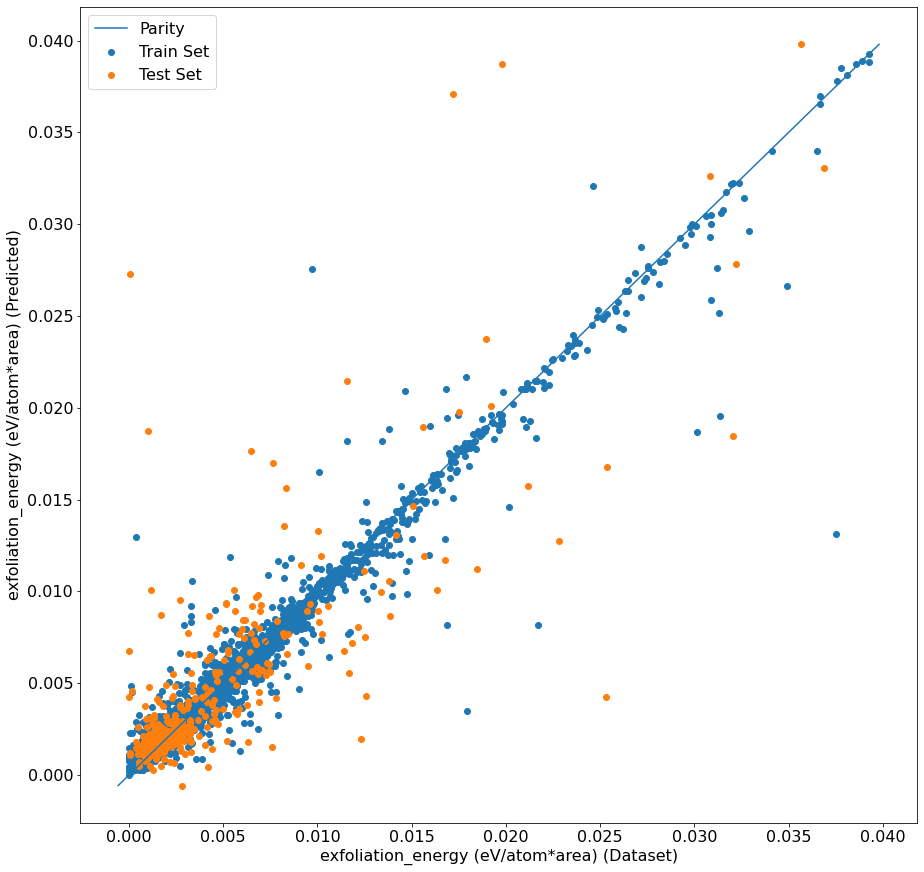

In [17]:
cutoff= .04
DigitalEcosystem.utils.figures.save_parity_plot(train_x_regression[train_y_regression<cutoff, :],
                                                test_x_regression[test_y_regression<cutoff, :],
                                                train_y_regression[train_y_regression<cutoff],
                                                test_y_regression[test_y_regression<cutoff],
                                                best_regression,
                                                target_column,
                                                "exfoliation_per_atom_lessThanPoint4.jpeg")